# The Battle of Neighborhoods

## Exploring Venues in Jalandhar, India

## Table of Contents

- [Introduction](#Introduction)
- [Data Collection from APIs](#Data-Collection-from-APIs)
- [Foursquare API](#Foursquare-API)
- [Zomato API](#Zomato-API)
- [Data Cleaning](#Data-Cleaning)
- [Methodology](#Methodology)
- [Analysis](#Analysis)
- [Rating](#Rating)
- [Price](#Price)
- [Clustering](#Clustering)
- [Results](#Results)
- [Conclusion](#Conclusion)

<a id='Introduction'></a>
## Introduction

The aim of the project is to identify venues in __Jalandhar, India__ based on their rating and average prices. In this notebook, we will identify various venues in Jalandhar, India, using __Foursquare API and Zomato API__, to help visitors select the restaurants that suits them the most.

Whenever people visit a city they start looking for places to visit during their stay. There primarily look for places is based on the venue ratings across all venues and the average prices so that the location fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

<a id='Data-Collection-from-APIs'></a>
## Data Collection from APIs

To begin with, we will take a look at Jalandhar on the Map using the folium library.

We will also fetch the data from two different APIs.

__Foursquare API:__ We will use the Foursquare API to fetch venues in Jalandhar starting from the middle upto 20 Kilometers in each direction.

__Zomato API:__ The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

In [1]:
#-----Importing Libraries-------

import numpy as np           #library to handle data in a vectorized manner
import pandas as pd          #library for data analysis

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json                  #library to handle JSON files

from geopy.geocoders import Nominatim        #convert an address into latitude and longitude values

import requests             #library to handle requests
from pandas.io.json import json_normalize    #tranform JSON file into a pandas dataframe

#Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

#import k-means from clustering stage
from sklearn.cluster import KMeans

import folium               #map rendering library

print('Libraries imported.')

Libraries imported.


#### Use geopy library to get the latitude and longitude values of Jalandhar.

In order to define an instance of the geocoder, we need to define a user_agent.
We will name our agent <em>ny_explorer</em>, as shown below.

In [2]:
address = 'Jalandhar, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
jal_latitude = location.latitude
jal_longitude = location.longitude
print('The geograpical coordinate of Jalandhar are {}, {}.'.format(jal_latitude, jal_longitude))

The geograpical coordinate of Jalandhar are 31.29201065, 75.56805772253911.


#### Let's use the folium library to create a complete map zoomed on Jalandhar. We'll also plot a marker on the coordinates we just identified above.

In [3]:
jalandhar_map = folium.Map(location = [jal_latitude, jal_longitude], zoom_start = 13)

label = '{}, {}'.format(jal_latitude, jal_longitude)
label = folium.Popup(label, parse_html=True)
folium.Marker([jal_latitude, jal_longitude] , label).add_to(jalandhar_map)
jalandhar_map.save("maps//Jalandhar Map.html")
jalandhar_map

                 Zoom into the above map, and click on mark to reveal the latitude and longitude of Jalandhar.

<a id='Foursquare-API'></a>
## Foursquare API
We begin by fetching a total of all venues in Jalandhar upto a range of 20 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

#### Define Foursquare Credentials and Version 

In [44]:
CLIENT_ID = 'your Foursquare ID'     # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = 'Present Date'                # Foursquare API version

RADIUS = 20000 # 20 Km
NO_OF_VENUES = 100

We define the get_category_type method to get the correct category for each venue.

In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
We will set the radius as 20 Kilometers.
The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [6]:
offset = 0
total_venues = 0
jalandhar_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        jal_latitude, 
                                                                        jal_longitude, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
result = requests.get(url).json()
venues_fetched = len(result['response']['groups'][0]['items'])
total_venues = total_venues + venues_fetched
print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))
    
venues = result['response']['groups'][0]['items']
venues = json_normalize(venues)

Total 29 venues fetched within a total radius of 20.0 Km


Let's see the venues fetched.

In [7]:
venues.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4dc0ed96b0fb1c18ee57f8ed-0,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",4dc0ed96b0fb1c18ee57f8ed,Model Town,IN,Jalandhar,India,Dev Dutt Khullar Marg,1842,"[Model Town (Dev Dutt Khullar Marg), Jalandhar...","[{'label': 'display', 'lat': 31.306698, 'lng':...",31.306698,75.576999,Model Town,NaN,Punjab,KFC,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e2d97c262e144b5d3c24125-1,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",4e2d97c262e144b5d3c24125,Axis Building,IN,Jalandhar,India,BMC Chowk,3302,"[Axis Building (BMC Chowk), Jalandhar 144001, ...","[{'label': 'display', 'lat': 31.317733, 'lng':...",31.317733,75.585359,BMC Chowk,144001,Punjab,McDonald's,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5137806ee4b07b15e3915c20-2,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",5137806ee4b07b15e3915c20,"3rd Floor, Chunmun Mall",IN,Jalandhar,India,Ram Saran Marg,2542,"[3rd Floor, Chunmun Mall (Ram Saran Marg), Jal...","[{'label': 'display', 'lat': 31.31110017608066...",31.311100,75.582727,NaN,NaN,Punjab,The Brewmaster,0,[]
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ccd0d5d09b1b71389dadba6-3,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",4ccd0d5d09b1b71389dadba6,NaN,IN,Jalandhar,India,NaN,1892,"[Jalandhar, Punjab, India]","[{'label': 'display', 'lat': 31.30636772046139...",31.306368,75.578712,NaN,NaN,Punjab,Model Town,0,[]
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4db186b4f7b1bd003ade3d5e-4,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",4db186b4f7b1bd003ade3d5e,Model Town,IN,Jalandhar,India,NaN,1948,"[Model Town, Jalandhar 144003, Punjab, India]","[{'label': 'display', 'lat': 31.30695140137251...",31.306951,75.578732,Model Town,144003,Punjab,Subway,0,[]


Only required columns are fetched and *venues* dataframe is updated.

In [8]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
venues = venues.loc[:, filtered_columns]
venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,KFC,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",31.306698,75.576999
1,McDonald's,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",31.317733,75.585359
2,The Brewmaster,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",31.311100,75.582727
3,Model Town,"[{'id': '4f2a25ac4b909258e854f55f', 'name': 'N...",31.306368,75.578712
4,Subway,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",31.306951,75.578732


In [9]:
# Filter the category for each row
venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

In [10]:
venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,KFC,American Restaurant,31.306698,75.576999
1,McDonald's,Fast Food Restaurant,31.317733,75.585359
2,The Brewmaster,Brewery,31.311100,75.582727
3,Model Town,Neighborhood,31.306368,75.578712
4,Subway,Sandwich Place,31.306951,75.578732


In [11]:
# Clean all column names
venues.columns = [col.split(".")[-1] for col in venues.columns]
jalandhar_venues = pd.concat([jalandhar_venues, venues], axis = 0, sort = False)

In [12]:
jalandhar_venues

,name,categories,lat,lng
0,KFC,American Restaurant,31.306698,75.576999
1,McDonald's,Fast Food Restaurant,31.317733,75.585359
2,The Brewmaster,Brewery,31.311100,75.582727
3,Model Town,Neighborhood,31.306368,75.578712
4,Subway,Sandwich Place,31.306951,75.578732
5,Cafe Coffee Day,Café,31.304850,75.581726
6,PVR Cinemas,Multiplex,31.319439,75.584520
7,Headquarter's Family Restaurant,Indian Restaurant,31.311818,75.582445
8,Haveli | हवेली,Indian Restaurant,31.277899,75.676576
9,Jalandhar | जलंधर | ਜਲੰਧਰ,City,31.312856,75.588961


The size of the dataframe

In [13]:
jalandhar_venues.shape

(29, 4)

<a id='Zomato-API'></a>
## Zomato API 

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and 
get more information regarding each venue.

- The query will be the name of the venue.
- The start defines from what offset we want to start, so we'll keep it at 0.
- The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
- We will supply the latitude and longitude values.
- We will set the sorting criteria as real_distance so each time we get the venue we're searching based on location coordinates.

#### Define Zomato Credential

In [14]:
user_key = {'user-key': 'YOUR API KEY'}  #YOUR API KEY

In [15]:
venues_information = []   #list

for index, row in jalandhar_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []   #list
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = user_key).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6).tolist())

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29


In [16]:
print(venues_information)

[['KFC', '31.3066103109', '75.5770500004', 450, 2, '4.4', 'Model Town Market, Model Town, Jalandhar'], ['SOHAN S ', '31.3151684741', '75.5823282525', 0, 1, '3.4', '579, New jawahar nagar, Jalandhar, Shastri Nagar, Jalandhar'], ['Brewmaster', '31.3110202525', '75.5827336013', 1200, 3, '3.5', 'New Jawahar Nagar, Model Town, Jalandhar'], ['Parkash Bakery', '31.3061614278', '75.5787387863', 500, 2, '4.1', '13 A, Model Town, Jalandhar'], ['Subway', '31.3068575252', '75.5787582323', 500, 2, '3.9', '540, Rainbow Road, Model Town, Jalandhar'], ['The Reefer Café & Eatery', '31.3055410000', '75.5809400000', 700, 2, '3.9', '398 L, Model Town Road, Model Town, Jalandhar'], ['Spaghetti Club', '31.3189150000', '75.5846350000', 550, 2, '3.5', '3rd Floor, PVR MBD Mall, Shastri Market, Jalandhar'], ['Express Vegetarian', '31.3118572444', '75.5789593980', 250, 1, '4.2', 'New Jawahar Nahar, Model Town, Jalandhar'], ['Subway', '31.2763400000', '75.6776000000', 500, 2, '4.1', 'G.T. Road, Jalandhar to Phagw

In [17]:
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['Venue', 'Latitude', 
                                             'Longitude', 'Price_for_two', 
                                             'Price_range', 'Rating', 'Address'])
zomato_venues

,Venue,Latitude,Longitude,Price_for_two,Price_range,Rating,Address
0,KFC,31.3066103109,75.5770500004,450.0,2.0,4.4,"Model Town Market, Model Town, Jalandhar"
1,SOHAN S,31.3151684741,75.5823282525,0.0,1.0,3.4,"579, New jawahar nagar, Jalandhar, Shastri Nag..."
2,Brewmaster,31.3110202525,75.5827336013,1200.0,3.0,3.5,"New Jawahar Nagar, Model Town, Jalandhar"
3,Parkash Bakery,31.3061614278,75.5787387863,500.0,2.0,4.1,"13 A, Model Town, Jalandhar"
4,Subway,31.3068575252,75.5787582323,500.0,2.0,3.9,"540, Rainbow Road, Model Town, Jalandhar"
5,The Reefer Café & Eatery,31.3055410000,75.5809400000,700.0,2.0,3.9,"398 L, Model Town Road, Model Town, Jalandhar"
6,Spaghetti Club,31.3189150000,75.5846350000,550.0,2.0,3.5,"3rd Floor, PVR MBD Mall, Shastri Market, Jalan..."
7,Express Vegetarian,31.3118572444,75.5789593980,250.0,1.0,4.2,"New Jawahar Nahar, Model Town, Jalandhar"
8,Subway,31.2763400000,75.6776000000,500.0,2.0,4.1,"G.T. Road, Jalandhar to Phagwara Highway, Have..."
9,Raja Hotel,31.3136130000,75.5893310000,500.0,2.0,3.5,"945, Garha Road, Near Bus Stand, Model Town, J..."


<a id='Data-Cleaning'></a>
## Data Cleaning 
The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [18]:
jalandhar_map = folium.Map(location = [jal_latitude, jal_longitude], zoom_start = 13)

for name, latitude, longitude in zip(jalandhar_venues['name'], jalandhar_venues['lat'], jalandhar_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(jalandhar_map)  

jalandhar_map.save("maps//Venues by Foursquare.html")
jalandhar_map

We will also plot the Zomato data on the map

In [19]:
jalandhar_map = folium.Map(location = [jal_latitude, jal_longitude], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['Venue'], zomato_venues['Address'], 
                                               zomato_venues['Latitude'], zomato_venues['Longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(jalandhar_map)  

jalandhar_map.save("maps//Venues by Zomato.html")
jalandhar_map

We can see that there are some venues identified by both Foursquare and Zomato.

To combine the two datasets, We'll have to check that the latitude and longitude values of each corresponding venue match. Thus, We'll round both the latitude and longitude values upto 4 decimal places. Then, We'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [20]:
#Foursquare
jalandhar_venues['lat']   = jalandhar_venues['lat'].apply(lambda lat: round(float(lat), 4))
jalandhar_venues['lng']   = jalandhar_venues['lng'].apply(lambda lng: round(float(lng), 4))

#Zomato
zomato_venues['Latitude'] = zomato_venues['Latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['Longitude'] = zomato_venues['Longitude'].apply(lambda lng: round(float(lng), 4))

In [21]:
four_zomato_concat_data = pd.concat([jalandhar_venues, zomato_venues], axis = 1)
four_zomato_concat_data

,name,categories,lat,lng,Venue,Latitude,Longitude,Price_for_two,Price_range,Rating,Address
0,KFC,American Restaurant,31.3067,75.5770,KFC,31.3066,75.5771,450.0,2.0,4.4,"Model Town Market, Model Town, Jalandhar"
1,McDonald's,Fast Food Restaurant,31.3177,75.5854,SOHAN S,31.3152,75.5823,0.0,1.0,3.4,"579, New jawahar nagar, Jalandhar, Shastri Nag..."
2,The Brewmaster,Brewery,31.3111,75.5827,Brewmaster,31.3110,75.5827,1200.0,3.0,3.5,"New Jawahar Nagar, Model Town, Jalandhar"
3,Model Town,Neighborhood,31.3064,75.5787,Parkash Bakery,31.3062,75.5787,500.0,2.0,4.1,"13 A, Model Town, Jalandhar"
4,Subway,Sandwich Place,31.3070,75.5787,Subway,31.3069,75.5788,500.0,2.0,3.9,"540, Rainbow Road, Model Town, Jalandhar"
5,Cafe Coffee Day,Café,31.3048,75.5817,The Reefer Café & Eatery,31.3055,75.5809,700.0,2.0,3.9,"398 L, Model Town Road, Model Town, Jalandhar"
6,PVR Cinemas,Multiplex,31.3194,75.5845,Spaghetti Club,31.3189,75.5846,550.0,2.0,3.5,"3rd Floor, PVR MBD Mall, Shastri Market, Jalan..."
7,Headquarter's Family Restaurant,Indian Restaurant,31.3118,75.5824,Express Vegetarian,31.3119,75.5790,250.0,1.0,4.2,"New Jawahar Nahar, Model Town, Jalandhar"
8,Haveli | हवेली,Indian Restaurant,31.2779,75.6766,Subway,31.2763,75.6776,500.0,2.0,4.1,"G.T. Road, Jalandhar to Phagwara Highway, Have..."
9,Jalandhar | जलंधर | ਜਲੰਧਰ,City,31.3129,75.5890,Raja Hotel,31.3136,75.5893,500.0,2.0,3.5,"945, Garha Road, Near Bus Stand, Model Town, J..."


In [22]:
four_zomato_concat_data['lat_diff'] = four_zomato_concat_data['Latitude'] -  four_zomato_concat_data['lat']
four_zomato_concat_data['lng_diff'] = four_zomato_concat_data['Longitude'] - four_zomato_concat_data['lng']

In [23]:
selected_venues = ( four_zomato_concat_data[(abs(four_zomato_concat_data['lat_diff']) <= 0.0004)
                                          & (abs(four_zomato_concat_data['lng_diff']) <= 0.0004)].reset_index(drop = True) )
selected_venues

,name,categories,lat,lng,Venue,Latitude,Longitude,Price_for_two,Price_range,Rating,Address,lat_diff,lng_diff
0,KFC,American Restaurant,31.3067,75.5770,KFC,31.3066,75.5771,450.0,2.0,4.4,"Model Town Market, Model Town, Jalandhar",-0.0001,0.0001
1,The Brewmaster,Brewery,31.3111,75.5827,Brewmaster,31.3110,75.5827,1200.0,3.0,3.5,"New Jawahar Nagar, Model Town, Jalandhar",-0.0001,0.0000
2,Model Town,Neighborhood,31.3064,75.5787,Parkash Bakery,31.3062,75.5787,500.0,2.0,4.1,"13 A, Model Town, Jalandhar",-0.0002,0.0000
3,Subway,Sandwich Place,31.3070,75.5787,Subway,31.3069,75.5788,500.0,2.0,3.9,"540, Rainbow Road, Model Town, Jalandhar",-0.0001,0.0001
4,Subway,Sandwich Place,31.2985,75.5882,Subway,31.2984,75.5883,500.0,2.0,4.0,"SCO 85, Phase 2 Market, Urban Estate, Jalandhar",-0.0001,0.0001
5,Platoon Pizza,Pizza Place,31.3048,75.5819,Platoon Pizza,31.3047,75.5819,600.0,2.0,3.8,"370-R, Model Town, Jalandhar",-0.0001,0.0000
6,Baskin-Robbins,Ice Cream Shop,31.3114,75.5827,Baskin Robbins,31.3111,75.5828,200.0,1.0,3.9,"New Jawahar Nagar, Model Town, Jalandhar",-0.0003,0.0001
7,Domino's Pizza,Pizza Place,31.3260,75.5760,My Pizza,31.3259,75.5759,300.0,1.0,3.4,"Shop Area 2, Nakodar Road, Jyoti Chowk, Shastr...",-0.0001,-0.0001
8,KFC,Burger Joint,31.2876,75.6617,KFC,31.2875,75.6617,450.0,2.0,3.8,"Khasra 867/868, Jalandhar Phagwara Highway, Vi...",-0.0001,0.0000
9,Domino's Pizza,Pizza Place,31.3080,75.5790,Red Chilly,31.3077,75.5790,300.0,1.0,2.7,"Opp. nikku park, Model town, Jalandhar",-0.0003,0.0000


__Taking a look at the names of venues from both APIs, some names are a complete mismatch.__

1. Two locations are so close by that they have practically same latitude and longitude values.
2. There are venues that have specific restaurants/cafes inside them as provided by Zomato API.

The venues which belong to __*category 2*__ are alright to keep, the venues that fall in __*category 1*__ should be removed.

In [24]:
selected_venues = selected_venues.drop([ 7 , 9 ]).reset_index(drop = True)

In [25]:
selected_venues

,name,categories,lat,lng,Venue,Latitude,Longitude,Price_for_two,Price_range,Rating,Address,lat_diff,lng_diff
0,KFC,American Restaurant,31.3067,75.5770,KFC,31.3066,75.5771,450.0,2.0,4.4,"Model Town Market, Model Town, Jalandhar",-0.0001,0.0001
1,The Brewmaster,Brewery,31.3111,75.5827,Brewmaster,31.3110,75.5827,1200.0,3.0,3.5,"New Jawahar Nagar, Model Town, Jalandhar",-0.0001,0.0000
2,Model Town,Neighborhood,31.3064,75.5787,Parkash Bakery,31.3062,75.5787,500.0,2.0,4.1,"13 A, Model Town, Jalandhar",-0.0002,0.0000
3,Subway,Sandwich Place,31.3070,75.5787,Subway,31.3069,75.5788,500.0,2.0,3.9,"540, Rainbow Road, Model Town, Jalandhar",-0.0001,0.0001
4,Subway,Sandwich Place,31.2985,75.5882,Subway,31.2984,75.5883,500.0,2.0,4.0,"SCO 85, Phase 2 Market, Urban Estate, Jalandhar",-0.0001,0.0001
5,Platoon Pizza,Pizza Place,31.3048,75.5819,Platoon Pizza,31.3047,75.5819,600.0,2.0,3.8,"370-R, Model Town, Jalandhar",-0.0001,0.0000
6,Baskin-Robbins,Ice Cream Shop,31.3114,75.5827,Baskin Robbins,31.3111,75.5828,200.0,1.0,3.9,"New Jawahar Nagar, Model Town, Jalandhar",-0.0003,0.0001
7,KFC,Burger Joint,31.2876,75.6617,KFC,31.2875,75.6617,450.0,2.0,3.8,"Khasra 867/868, Jalandhar Phagwara Highway, Vi...",-0.0001,0.0000
8,Radisson Hotel,Hotel,31.3191,75.5852,The Great Indian Kabab Factory,31.3191,75.5850,0.0,1.0,3.4,"Radisson Hotel, GT Road, Jalandhar Cantt, Jala...",0.0000,-0.0002
9,MBD Neopolis Mall,Shopping Mall,31.3194,75.5845,Subway,31.3193,75.5845,500.0,2.0,3.6,"Food Court, 3rd Floor, MBD Neopolis Mall, Jala...",-0.0001,0.0000


Get the average price per person by dividing the column Price_for_two by 2.

In [26]:
selected_venues['Average Price per Person'] = selected_venues['Price_for_two']/2

The unnecessary columns are removed from the dataframe selected_venues.

In [27]:
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'Price_for_two'])

Let's look at the final dataframe now

In [28]:
selected_venues

,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person
0,American Restaurant,KFC,31.3066,75.5771,2.0,4.4,"Model Town Market, Model Town, Jalandhar",225.0
1,Brewery,Brewmaster,31.3110,75.5827,3.0,3.5,"New Jawahar Nagar, Model Town, Jalandhar",600.0
2,Neighborhood,Parkash Bakery,31.3062,75.5787,2.0,4.1,"13 A, Model Town, Jalandhar",250.0
3,Sandwich Place,Subway,31.3069,75.5788,2.0,3.9,"540, Rainbow Road, Model Town, Jalandhar",250.0
4,Sandwich Place,Subway,31.2984,75.5883,2.0,4.0,"SCO 85, Phase 2 Market, Urban Estate, Jalandhar",250.0
5,Pizza Place,Platoon Pizza,31.3047,75.5819,2.0,3.8,"370-R, Model Town, Jalandhar",300.0
6,Ice Cream Shop,Baskin Robbins,31.3111,75.5828,1.0,3.9,"New Jawahar Nagar, Model Town, Jalandhar",100.0
7,Burger Joint,KFC,31.2875,75.6617,2.0,3.8,"Khasra 867/868, Jalandhar Phagwara Highway, Vi...",225.0
8,Hotel,The Great Indian Kabab Factory,31.3191,75.5850,1.0,3.4,"Radisson Hotel, GT Road, Jalandhar Cantt, Jala...",0.0
9,Shopping Mall,Subway,31.3193,75.5845,2.0,3.6,"Food Court, 3rd Floor, MBD Neopolis Mall, Jala...",250.0


In [29]:
col = ['categories']
selected_venues.loc[2,col]='Model Town Neighborhood'

Let's drop the venue which has 0.0 rating as it means it's not been rated yet.

In [30]:
selected_venues = selected_venues[selected_venues['Rating'] != 0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 10


It can be observed that not a large no. of venues are available for doing the analysis.

<a id='Methodology'></a>
## Methodology 

This project aims at identifying the venues in __Jalandhar__ based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on the rating and their cost preferences.

As a first step, we retrieved the data from __two APIs (Foursquare and Zomato)__. We extracted venue information from the center of Jalandhar, upto a distance of 20 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options.Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

__Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and average cost.__

<a id='Analysis'></a>
## Analysis

We will inspect the venues based on their rating. The rating of a venue is based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

__We have different types of venues in the final dataset. Let's look at the Categories -__

<BarContainer object of 9 artists>

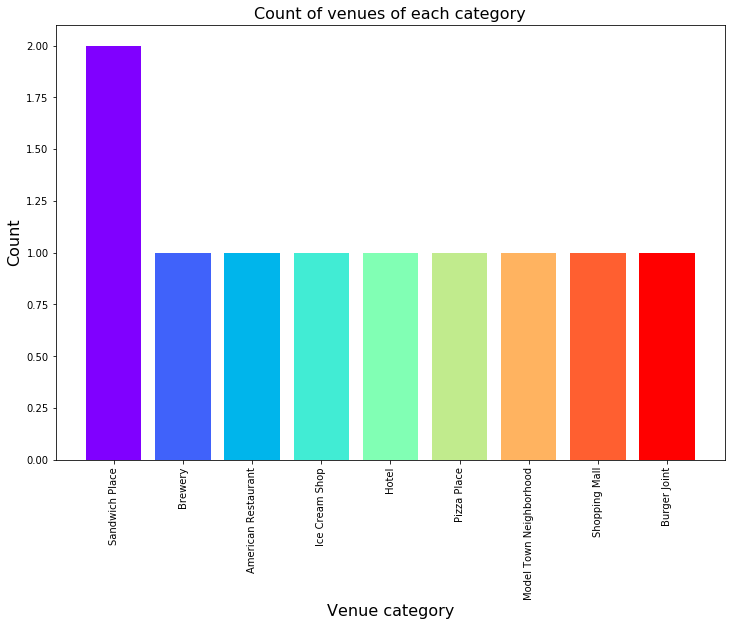

In [31]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (12, 8))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As the data retrieved for venues of Jalandhar was not very large , It can be observed from bar-chart that except __Sandwich Place Category__, all other __Venue Categories__ have only one venue each.

<a id='Rating'></a>
## Rating 

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place.

The ratings are plotted on the Bar-Plot to see the most common ratings.

C:\Users\sakshi aggarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Count of venues with given rating')

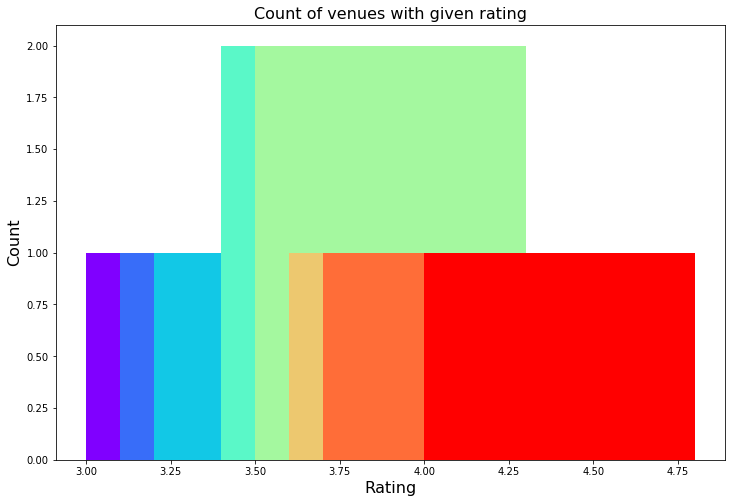

In [32]:
selected_venues['Rating'] = selected_venues['Rating'].astype(float)
rating = selected_venues['Rating'].value_counts().sort_index()
plt.figure(figsize = (12, 8))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot it is clear that majority venues have a rating between 3.5 to 4. 

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

- 1 to 2
- 2 to 3
- 3 to 4
- 4 to 5

In [33]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very Good']
selected_venues['Rating_bin'] = pd.cut(selected_venues['Rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

C:\Users\sakshi aggarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
selected_venues

,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person,Rating_bin
0,American Restaurant,KFC,31.3066,75.5771,2.0,4.4,"Model Town Market, Model Town, Jalandhar",225.0,Very Good
1,Brewery,Brewmaster,31.3110,75.5827,3.0,3.5,"New Jawahar Nagar, Model Town, Jalandhar",600.0,Good
2,Model Town Neighborhood,Parkash Bakery,31.3062,75.5787,2.0,4.1,"13 A, Model Town, Jalandhar",250.0,Very Good
3,Sandwich Place,Subway,31.3069,75.5788,2.0,3.9,"540, Rainbow Road, Model Town, Jalandhar",250.0,Good
4,Sandwich Place,Subway,31.2984,75.5883,2.0,4.0,"SCO 85, Phase 2 Market, Urban Estate, Jalandhar",250.0,Good
5,Pizza Place,Platoon Pizza,31.3047,75.5819,2.0,3.8,"370-R, Model Town, Jalandhar",300.0,Good
6,Ice Cream Shop,Baskin Robbins,31.3111,75.5828,1.0,3.9,"New Jawahar Nagar, Model Town, Jalandhar",100.0,Good
7,Burger Joint,KFC,31.2875,75.6617,2.0,3.8,"Khasra 867/868, Jalandhar Phagwara Highway, Vi...",225.0,Good
8,Hotel,The Great Indian Kabab Factory,31.3191,75.5850,1.0,3.4,"Radisson Hotel, GT Road, Jalandhar Cantt, Jala...",0.0,Good
9,Shopping Mall,Subway,31.3193,75.5845,2.0,3.6,"Food Court, 3rd Floor, MBD Neopolis Mall, Jala...",250.0,Good


Now, we will plot the venues on map.

In [35]:
color_map = {'Low': 'darkgreen', 'Okay': 'green', 'Good': 'orange', 'Very Good': 'red'}

jalandhar_map = folium.Map(location = [jal_latitude, jal_longitude], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['Venue'], 
                                                          selected_venues['Address'], 
                                                          selected_venues['Latitude'], 
                                                          selected_venues['Longitude'], 
                                                          selected_venues['Rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(jalandhar_map)  

jalandhar_map.save("maps//Venues Ratings.html")
jalandhar_map

The map has the location of all the venues available. It appears that many venues are located in __Model Town__ with rating above 3.5. If someone wants to explore new venues, they should definitely check out __Model Town__.

<a id='Price'></a>
## Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is average_price which defines the Average cost per person and the other is Price_range which determines the price range as defined by Zomato.

We will first explore the average_price using a scatter plot between the price and the count of venues with that average price. __We'll size the points based on the price to highlight their price.__

Text(0.5,1,'Count of venues with given average price')

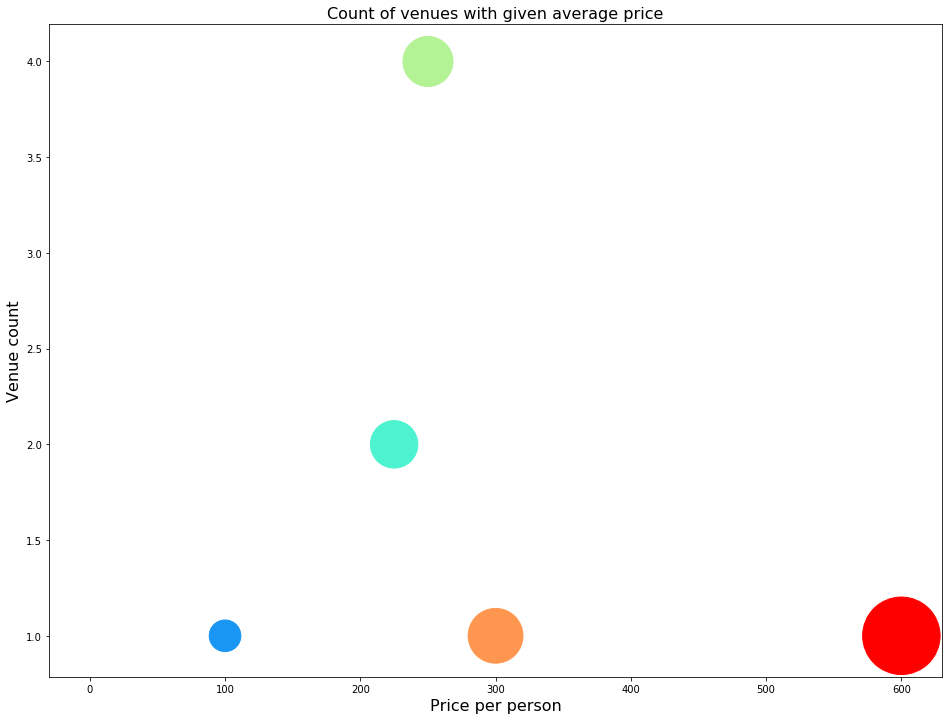

In [36]:
average_prices = selected_venues['Average Price per Person'].value_counts().sort_index()
plt.figure(figsize = (16, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a most venues have an average price between Rs 200 and Rs 300.

We'll use the __Price_range column__ to plot the venues on a map.
Venues with __lower price range__ are represented with __green color__ and __high price range__ with __red color__.

In [37]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

jalandhar_map = folium.Map(location = [jal_latitude, jal_longitude], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['Venue'], 
                                                           selected_venues['Address'], 
                                                           selected_venues['Latitude'], 
                                                           selected_venues['Longitude'], 
                                                           selected_venues['Price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(jalandhar_map)  

jalandhar_map.save("maps//Venues Prices.html")
jalandhar_map

__Observations from map :__
1. Venues with good ratings are located in Model Town.
2. Model Town seems to have average to high priced venues.

<a id='Clustering'></a>
## Clustering

We will now cluster all these venues based on their Price range, Location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [38]:
NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['Venue', 'Address', 'Rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)

In [39]:
selected_venues

,cluster_labels,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person,Rating_bin
0,0,American Restaurant,KFC,31.3066,75.5771,2.0,4.4,"Model Town Market, Model Town, Jalandhar",225.0,Very Good
1,1,Brewery,Brewmaster,31.3110,75.5827,3.0,3.5,"New Jawahar Nagar, Model Town, Jalandhar",600.0,Good
2,0,Model Town Neighborhood,Parkash Bakery,31.3062,75.5787,2.0,4.1,"13 A, Model Town, Jalandhar",250.0,Very Good
3,0,Sandwich Place,Subway,31.3069,75.5788,2.0,3.9,"540, Rainbow Road, Model Town, Jalandhar",250.0,Good
4,0,Sandwich Place,Subway,31.2984,75.5883,2.0,4.0,"SCO 85, Phase 2 Market, Urban Estate, Jalandhar",250.0,Good
5,0,Pizza Place,Platoon Pizza,31.3047,75.5819,2.0,3.8,"370-R, Model Town, Jalandhar",300.0,Good
6,0,Ice Cream Shop,Baskin Robbins,31.3111,75.5828,1.0,3.9,"New Jawahar Nagar, Model Town, Jalandhar",100.0,Good
7,0,Burger Joint,KFC,31.2875,75.6617,2.0,3.8,"Khasra 867/868, Jalandhar Phagwara Highway, Vi...",225.0,Good
8,0,Hotel,The Great Indian Kabab Factory,31.3191,75.5850,1.0,3.4,"Radisson Hotel, GT Road, Jalandhar Cantt, Jala...",0.0,Good
9,0,Shopping Mall,Subway,31.3193,75.5845,2.0,3.6,"Food Court, 3rd Floor, MBD Neopolis Mall, Jala...",250.0,Good


Let's plot the clusters on the map.

In [40]:
jalandhar_map = folium.Map(location = [jal_latitude, jal_longitude], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['Venue'], 
                                                        selected_venues['Address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['Latitude'], 
                                                        selected_venues['Longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(jalandhar_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(jalandhar_map)

jalandhar_map.save("maps//Venues Clusters.html")
jalandhar_map

From the map, it can be observed that most venues fall under __Cluster 0__.

### Cluster 0 

In [41]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.reset_index(drop = True)

Cluster 0


,cluster_labels,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person,Rating_bin
0,0,American Restaurant,KFC,31.3066,75.5771,2.0,4.4,"Model Town Market, Model Town, Jalandhar",225.0,Very Good
1,0,Model Town Neighborhood,Parkash Bakery,31.3062,75.5787,2.0,4.1,"13 A, Model Town, Jalandhar",250.0,Very Good
2,0,Sandwich Place,Subway,31.3069,75.5788,2.0,3.9,"540, Rainbow Road, Model Town, Jalandhar",250.0,Good
3,0,Sandwich Place,Subway,31.2984,75.5883,2.0,4.0,"SCO 85, Phase 2 Market, Urban Estate, Jalandhar",250.0,Good
4,0,Pizza Place,Platoon Pizza,31.3047,75.5819,2.0,3.8,"370-R, Model Town, Jalandhar",300.0,Good
5,0,Ice Cream Shop,Baskin Robbins,31.3111,75.5828,1.0,3.9,"New Jawahar Nagar, Model Town, Jalandhar",100.0,Good
6,0,Burger Joint,KFC,31.2875,75.6617,2.0,3.8,"Khasra 867/868, Jalandhar Phagwara Highway, Vi...",225.0,Good
7,0,Hotel,The Great Indian Kabab Factory,31.3191,75.5850,1.0,3.4,"Radisson Hotel, GT Road, Jalandhar Cantt, Jala...",0.0,Good
8,0,Shopping Mall,Subway,31.3193,75.5845,2.0,3.6,"Food Court, 3rd Floor, MBD Neopolis Mall, Jala...",250.0,Good


In [42]:
print("These venues for cluster 0 have Average price per person of {:.02f} and rating spread around {:.02f}".
      format(result['Average Price per Person'].mean(), result['Rating'].astype(float).mean()))

These venues for cluster 0 have Average price per person of 205.56 and rating spread around 3.88


### Cluster 1 

In [43]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.reset_index(drop = True)

Cluster 1


,cluster_labels,categories,Venue,Latitude,Longitude,Price_range,Rating,Address,Average Price per Person,Rating_bin
0,1,Brewery,Brewmaster,31.311,75.5827,3.0,3.5,"New Jawahar Nagar, Model Town, Jalandhar",600.0,Good


<a id='Results'></a>
## Results

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting __Jalandhar, India__.

After collecting data from the __Foursquare and Zomato APIs__, we got a list of __29 different venues__. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 10.

We identified that from the total set of venues, majority of them were __Sandwich and Pizza Places__.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there is cluster of venues around __Model Town__. The cluster also have high rating (more than 3).

When we take a look at the price values of each venue, we explore that many venues have prices which are in the range of __Rs 200 to Rs 300__ for one person. Also , it's been observed that Model Town seems to have average to high priced venues.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of __3.88__.

__So, If you're looking to explore the city and have no specific criteria to decide upon the places you want to visit, you should try Model Town__.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

<a id='Conclusion'></a>
## Conclusion

The purpose of this project was to explore the places that a person visiting Jalandhar could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that the major area in Jalandhar to visit is Model Town. Based on the visitor's venue rating and price requirements, he/she can choose places.